In [94]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 MB 12.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 12.3 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.9.0
    Uninstalling typing_extensions-4.9.0:
      Successfully uninstalled typing_extensions-4.9.0
  Attempting uninstall: sympy
    Found existing installation: sympy 1.12
    Uninstalling sympy-1.12:
      Successfully uninstalled sympy-1.12


In [95]:
!pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.5 MB/s eta 0:00:00


# Loading pytorch

In [4]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



In [28]:
# data_dir = 'data_trytorch/hymenoptera_data'

DATA_DIR = './age_pt/'

data_dir = DATA_DIR

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# https://developer.apple.com/metal/pytorch/
device = torch.device("mps")

In [29]:
device

device(type='mps')

In [30]:
class_names

['0', '13', '2', '6', '8']

In [31]:
# import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


## Visualize a few images

In [32]:
def imshow(inp, title=None):
    
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated



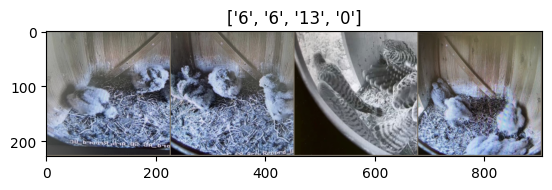

In [33]:

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title = [class_names[x] for x in classes])

## Training the model

In [34]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.float() / dataset_sizes[phase] ## changing due to M2

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

## Visualizing the model predictions

In [35]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[predbms[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning ResNet

In [36]:
NUMBER_OF_CLASSES = len(class_names)

In [37]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.



model_ft.fc = nn.Linear(num_ftrs, NUMBER_OF_CLASSES) # training time vs. number of classes

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss() # why is criterion and optimizer "on top"

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr = 0.001, momentum = 0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 7, gamma = 0.1)

## Train and evaluate

In [38]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs = 25)

Epoch 0/24
----------
train Loss: 1.1845 Acc: 0.5250
val Loss: 0.2497 Acc: 0.9200

Epoch 1/24
----------
train Loss: 0.7248 Acc: 0.7250
val Loss: 0.1004 Acc: 0.9600

Epoch 2/24
----------
train Loss: 0.2925 Acc: 0.8850
val Loss: 0.0122 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.2572 Acc: 0.9150
val Loss: 0.0043 Acc: 1.0000

Epoch 4/24
----------
train Loss: 0.2811 Acc: 0.9000
val Loss: 0.0006 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.2430 Acc: 0.9400
val Loss: 0.0013 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.3279 Acc: 0.8950
val Loss: 0.0041 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.1866 Acc: 0.9500
val Loss: 0.0028 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.1790 Acc: 0.9350
val Loss: 0.0015 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.1685 Acc: 0.9500
val Loss: 0.0017 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.1810 Acc: 0.9400
val Loss: 0.0012 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.1307 Acc: 0.9550
val Loss: 0.0009 Acc: 1.0000

Ep

In [17]:
import torch.nn.functional as F

In [23]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode = was_training) #https://stackoverflow.com/questions/69371652/what-is-model-training-in-pytorch

        # print(outputs, _, preds, preds[0])
        # https://stackoverflow.com/questions/71788074/how-to-get-the-roc-curve-of-a-neural-network
        probabilities = F.softmax(outputs, dim=1)[:, 1]
        print(probabilities)
        return probabilities


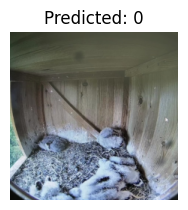

tensor([0.0402], device='mps:0')


In [39]:
data_dir = '/Users/vitaly/Lehre/WS2425/Falken/data/age/'
u = visualize_model_predictions(
    model_ft,

    # img_path = data_dir + '1/2024-05-22_10:03:11_Flattern und Mausklau.mov_1.jpg'
    img_path = data_dir + '3/2024-05-24_12:53:32_geht doch.mov_426.jpg'
    # img_path = data_dir + '3/2024-05-24_12:53:32_geht doch.mov_587.jpg'
    # img_path = '/Users/vitaly/Lehre/WS2425/Falken/data/segment/3/2024-05-24_12:53:32_geht doch.mov_769.jpg'
     # img_path = data_dir + '7/2024-05-28_11:55:15_Maus entrissen und verschlungen.mov_571.jpg'
    # img_path = data_dir + '6/2024-05-27_12:48:56_da staunste.mov_1962.jpg'
    
)

plt.ioff()
plt.show()

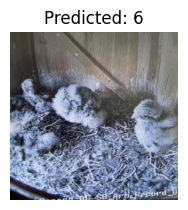

tensor([2.0358e-06], device='mps:0')


In [40]:
data_dir = '/Users/vitaly/Lehre/WS2425/Falken/data/age/'
u = visualize_model_predictions(
    model_ft,

    # img_path = data_dir + '1/2024-05-22_10:03:11_Flattern und Mausklau.mov_1.jpg'
    # img_path = data_dir + '3/2024-05-24_12:53:32_geht doch.mov_426.jpg'
    # img_path = data_dir + '3/2024-05-24_12:53:32_geht doch.mov_587.jpg'
    # img_path = '/Users/vitaly/Lehre/WS2425/Falken/data/segment/3/2024-05-24_12:53:32_geht doch.mov_769.jpg'
     # img_path = data_dir + '7/2024-05-28_11:55:15_Maus entrissen und verschlungen.mov_571.jpg'
    img_path = data_dir + '6/2024-05-27_12:48:56_da staunste.mov_1962.jpg'
    
)

plt.ioff()
plt.show()

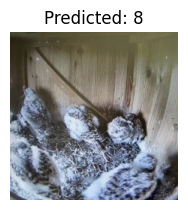

tensor([9.9380e-05], device='mps:0')


In [41]:
data_dir = '/Users/vitaly/Lehre/WS2425/Falken/data/age/'
u = visualize_model_predictions(
    model_ft,

    # img_path = data_dir + '1/2024-05-22_10:03:11_Flattern und Mausklau.mov_1.jpg'
    # img_path = data_dir + '3/2024-05-24_12:53:32_geht doch.mov_426.jpg'
    # img_path = data_dir + '3/2024-05-24_12:53:32_geht doch.mov_587.jpg'
    # img_path = '/Users/vitaly/Lehre/WS2425/Falken/data/segment/3/2024-05-24_12:53:32_geht doch.mov_769.jpg'
     img_path = data_dir + '7/2024-05-28_11:55:15_Maus entrissen und verschlungen.mov_571.jpg'
    # img_path = data_dir + '6/2024-05-27_12:48:56_da staunste.mov_1962.jpg'
    
)

plt.ioff()
plt.show()

In [135]:
def visualize_model_predictions_multi(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        

        # ax = plt.subplot(2,2,1)
        # ax.axis('off')
        # ax.set_title(f'Predicted: {class_names[preds[0]]}')
        # imshow(img.cpu().data[0])

        model.train(mode = was_training) #https://stackoverflow.com/questions/69371652/what-is-model-training-in-pytorch

        # print(outputs, _, preds, preds[0])
        # https://stackoverflow.com/questions/71788074/how-to-get-the-roc-curve-of-a-neural-network
        
        #print(outputs)
        # probabilities = F.softmax(outputs, dim = 1)[:, 1]
        
        #print("probabilities:", F.softmax(outputs, dim = 1))
        # probabilities = F.softmax(outputs, dim = 1)
        # print("probabilities:", probabilities.item())
        # return probabilities, class_names[preds[0]]
        
        return class_names[preds[0]] # just to make predictions
        
        #print([x for x in outputs.cpu().detach().numpy().tolist()])
        
        #return F.softmax(outputs, dim = 1)# produces all the probabilities of classes




In [137]:
DATA_DIR = '/Users/vitaly/Lehre/WS2425/Falken/data/age_pt/'


y = []
y_pred = []
for w in [0,2,6,8,13]:
    
    DIR = DATA_DIR + '/val/' + str(w) + '/'
    y1 = [str(w) for i in range(len(os.listdir(DIR)))]
    y += y1

    
    for el in os.listdir(DIR):
        # u, cl = visualize_model_predictions_multi(model_ft,img_path = DIR + el)
        cl = visualize_model_predictions_multi(model_ft, img_path = DIR + el)
        # print(u,cl)
        
        # y_pred.append(cl.cpu().detach().numpy().tolist()[0])
        
        y_pred.append(cl)

        
        # print(u.item())
        # scores.append(u.item())
        # break

In [128]:
y_true = y

In [138]:
y_pred

['0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '6',
 '6',
 '6',
 '6',
 '6',
 '6',
 '6',
 '6',
 '6',
 '6',
 '8',
 '8',
 '8',
 '8',
 '8',
 '8',
 '8',
 '8',
 '8',
 '8',
 '13',
 '13',
 '13',
 '13',
 '13',
 '13',
 '13',
 '13',
 '13',
 '13']

In [125]:
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 10.7 MB/s eta 0:00:0000:010:01


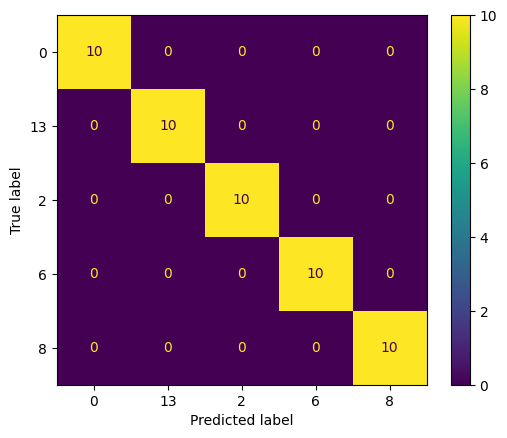

In [139]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.show()

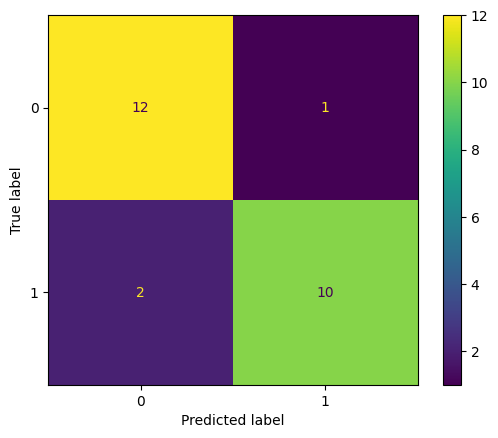

In [132]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
X, y = make_classification(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=0)
clf = SVC(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
ConfusionMatrixDisplay.from_predictions(
   y_test, y_pred)
plt.show()

In [134]:
y_pred

array([1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0])